## Data Workbook

In [8]:
# importing libraries
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import urllib.parse
import json
from urllib.request import urlopen
import requests # library to handle requests
from datetime import datetime



## Import 

Note the following; pre-analysis was used to determine following:
* selecting columns of interest to load
* selecting discrimination that pass certain threshold
* Later on, selecting only misdemeanor and felony
* Notice the query

In [205]:

# query parameter as a string
query = """
    SELECT 
        record_create_date as rDate,
        complaint_year_number as year,
        bias_motive_description as bias,
        offense_category as offense_Category,
        law_code_category_description as crime_Category,
        offense_description as offense,
        pd_code_description as description,
        county as borough,
        complaint_precinct_code as precinct,
        patrol_borough_name as borough_add,
        arrest_id
    WHERE
        bias_motive_description IN ('ANTI-JEWISH','ANTI-MALE HOMOSEXUAL (GAY)',
                                    'ANTI-ASIAN','ANTI-BLACK','ANTI-OTHER ETHNICITY',
                                    'ANTI-WHITE','ANTI-MUSLIM','ANTI-TRANSGENDER',
                                    'ANTI-HISPANIC','ANTI-CATHOLIC','ANTI-FEMALE HOMOSEXUAL (LESBIAN)')
        AND law_code_category_description IN ('FELONY','MISDEMEANOR')
    LIMIT
        10000
    """

# bqiq-cu78 is the data url for openData

url=f'https://data.cityofnewyork.us/resource/bqiq-cu78.json?$query={query}'
data= requests.get(url).json()
df=pd.DataFrame(data)
print(df.shape)
df.head(5)

(2961, 11)


rDate  year         bias             offense_Category  \
0  2019-12-12T00:00:00.000  2019  ANTI-JEWISH                 Unclassified   
1  2019-10-07T00:00:00.000  2019  ANTI-JEWISH  Religion/Religious Practice   
2  2019-06-13T00:00:00.000  2019  ANTI-JEWISH  Religion/Religious Practice   
3  2019-09-22T00:00:00.000  2019  ANTI-JEWISH  Religion/Religious Practice   
4  2019-10-21T00:00:00.000  2019  ANTI-JEWISH  Religion/Religious Practice   

  crime_Category                  offense              description   borough  \
0         FELONY  MISCELLANEOUS PENAL LAW  AGGRAVATED HARASSMENT 1  NEW YORK   
1         FELONY  MISCELLANEOUS PENAL LAW  AGGRAVATED HARASSMENT 1     BRONX   
2         FELONY  MISCELLANEOUS PENAL LAW  AGGRAVATED HARASSMENT 1     BRONX   
3         FELONY  MISCELLANEOUS PENAL LAW  AGGRAVATED HARASSMENT 1     BRONX   
4         FELONY  MISCELLANEOUS PENAL LAW  AGGRAVATED HARASSMENT 1     BRONX   

  precinct            borough_add arrest_id  
0       24  PATROL BORO MAN NORTH       NaN  
1       41      PATROL BORO BRONX       NaN  
2       46      PATROL BORO BRONX       NaN  
3       48      PATROL BORO BRONX       NaN  
4       48      PATROL BORO BRONX       NaN

## Preparing Columns [read the comments]

Some columns were excluded since not used
* The todate analysis was not used
* I've created monthly bins to measure time

In [211]:
# Fix up and rename values

# Column-bias; 
#Need remove "anti-", letter case, and change some values
df.bias=df.bias.str.replace('ANTI-','').str.title()
# Single Function action
def Bias(x):
    if x =='Male Homosexual (Gay)':
        return 'Gay'
    elif x =='Female Homosexual (Lesbian)':
        return 'Lesbian'
    else:
        return x

df.bias= df.bias.apply(Bias) #apply function

# Borough renaming
df.borough=df.borough.str.title()
def Borough(x):
    if x =='Kings':
        return 'Brooklyn'
    elif x =='Richmond':
        return 'Staten'
    if x =='New York':
        return 'Manhattan'
    else:
        return x

df.borough= df.borough.apply(Borough) #apply function

# Borugh_Add
df.borough_add=df.borough_add.str.replace('Patrol Boro ','').str.title() 
df.borough_add=df.borough_add.str.replace(' Island','')#,inplace=True)
df.borough_add=df.borough_add.str.replace(' South','_S')#,inplace=True)
df.borough_add=df.borough_add.str.replace(' North','_N')#,inplace=True)

df.crime_Category=df.crime_Category.str.title() #this column with not be used
df.offense=df.offense.str.title() # greater than 20 count be used
df.description=df.description.str.title() #this column will not be used

#DateTime Variables
df['dateTime']= pd.to_datetime(df['rDate']) # Create new column called DateTime
#df['dayofWeek']=df['dateTime'].dt.dayofweek #create day of the week column where default 0=Monday
#df['weekend'] = df['dayofWeek'].apply(lambda x: 1 if (x>4)  else 0) #Create a weekend category
df['month'] = df['dateTime'].dt.month # Create Month Category
#df['day'] = df['dateTime'].dt.day #Create Day of the Current month
df['dayYear'] = df['dateTime'].dt.dayofyear  #Create Day of the year (0-365)

def date_to_dayofyear(date_str):
    """Converts a date string to the day of the year."""

    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    return date_obj.timetuple().tm_yday

# Example usage
date_str = "2024-09-12"
day_of_year = date_to_dayofyear(date_str)
df['toDate']= date_to_dayofyear(date_str)

#binning time by month for longitudinal analysis
def Month_bin(year,month):
    if year=='2020':
        return 12 + month
    elif year=='2021':
        return 24 +month
    elif year=='2022':
        return 36 +month
    elif year=='2023':
        return 48 +month
    elif year=='2024':
        return 60 +month
    else:
        return month

df['month_bin']= df.apply(lambda y: Month_bin(y.year, y.month), axis=1)


# Shorten Offenses to a new table
def offense1(x):
    if x=="Assault 3 & Related Offenses":
        return "Assault"
    elif x=="Criminal Mischief & Related Of":
        return "Criminal Mischief"
    elif x in ["Felony Assault","Grand Larceny","Robbery"]:
        return x
    elif x=="Off. Agnst Pub Ord Sensblty &":
        return "Agst Public Order"
    elif x=="Miscellaneous Penal Law":
        return "Misc. Penal Law"
    else:
        return "Other"

df['offense1']=df.offense.apply(offense1)

#Create Index for grouping
df['index_']=1
df.tail(5)

#testing code
#p2=['offense','index_']
#pv=df[p2].groupby(['offense']).sum().reset_index()
#pv.columns=['offense','count']
#pv.query('count>20')


rDate  year    bias             offense_Category  \
2956  2024-03-09T00:00:00.000  2024   Asian                   Race/Color   
2957  2024-03-09T00:00:00.000  2024   Asian                   Race/Color   
2958  2024-03-09T00:00:00.000  2024   Asian                   Race/Color   
2959  2024-01-08T00:00:00.000  2024  Jewish  Religion/Religious Practice   
2960  2024-01-29T00:00:00.000  2024  Jewish  Religion/Religious Practice   

     crime_Category                       offense description    borough  \
2956    Misdemeanor  Assault 3 & Related Offenses   Assault 3  Manhattan   
2957    Misdemeanor  Assault 3 & Related Offenses   Assault 3  Manhattan   
2958    Misdemeanor  Assault 3 & Related Offenses   Assault 3  Manhattan   
2959    Misdemeanor  Assault 3 & Related Offenses   Assault 3  Manhattan   
2960    Misdemeanor  Assault 3 & Related Offenses   Assault 3  Manhattan   

     precinct borough_add  arrest_id   dateTime  month  dayYear  toDate  \
2956       14       Man_S  M36684260 2024-03-09      3       69     256   
2957       14       Man_S  M36684674 2024-03-09      3       69     256   
2958       14       Man_S  M36684675 2024-03-09      3       69     256   
2959       17       Man_S  M36673135 2024-01-08      1        8     256   
2960       18       Man_S  M36694620 2024-01-29      1       29     256   

      month_bin offense1  index_  
2956         63  Assault       1  
2957         63  Assault       1  
2958         63  Assault       1  
2959         61  Assault       1  
2960         61  Assault       1

## Basic Data Analysis
* Line Graphs first; I used monthly bins, and broken to smaller categories to reduce clutter
* Pie Graphs were next; created a function for easy use

In [ ]:
#Check ArrestID null values
print(df.shape)
print(df.query('arrest_id.isnull()').shape)
a=df.query('arrest_id.notnull()')
a.head(2)

#check count for Arrest ID
p1=['arrest_id','index_']
pf=df[p1].groupby(['arrest_id']).sum().reset_index()
pf.columns=['arrest','inc']
pf.inc.value_counts()

In [17]:
#Import Libraries & Load Data
import plotly.express as xp   # now it works
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import HTML
from IPython.display import display
import requests # library to handle requests
import folium
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
from IPython.display import Audio


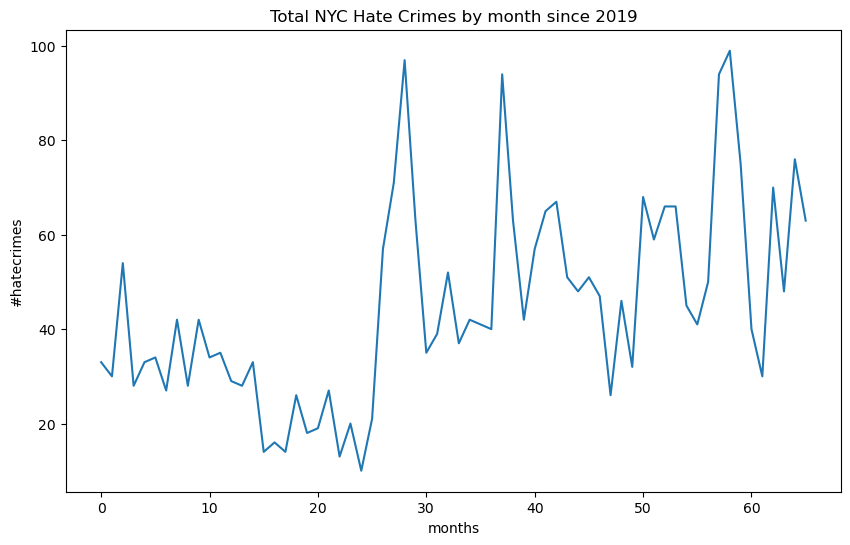

In [19]:
#Line Graph All Crime 

#Prepare Data
p1=['month_bin','index_']
pf=df[p1].groupby(['month_bin']).sum().reset_index()
pf.columns=['date','#hatecrimes']

#Prepare Graph
plt.figure(figsize=(10,6)) # Set the width and height of the figure
plt.title("Total NYC Hate Crimes by month since 2019")
bg=sns.lineplot(pf['#hatecrimes'])
plt.xlabel("months")
figure = bg.get_figure() 

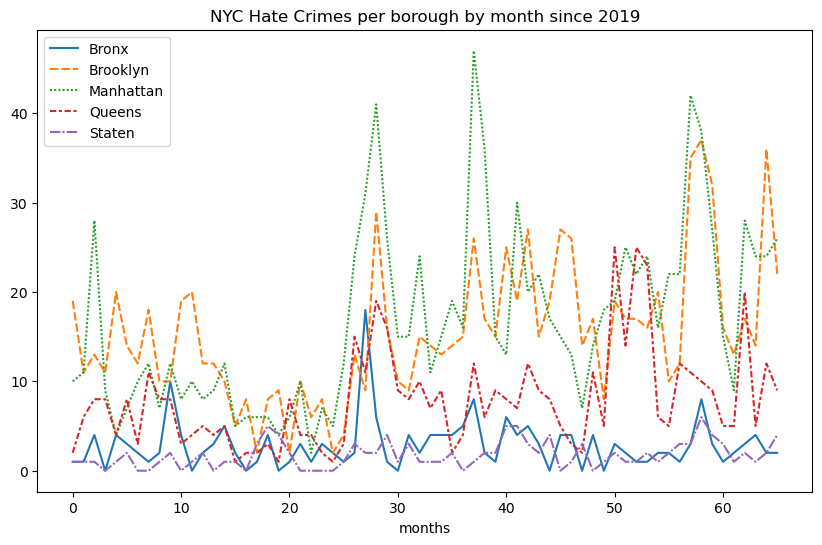

In [23]:
# Line Graph by borough; note the clutter was reason to not use expanded borough
#Prepare Data: Strategy is to use a pivot table to melt the data
p2=['month_bin','borough','index_']
pv=df[p2].groupby(['month_bin','borough']).sum().reset_index()
pv1=pd.pivot_table(pv,index='month_bin', columns='borough', values=['index_']).reset_index().fillna(0) #replace null values
#Renaming columns is important for indexing
pv1.columns= ['month','Bronx','Brooklyn','Manhattan','Queens','Staten']

# Graphing
plt.figure(figsize=(10,6))
plt.title("NYC Hate Crimes per borough by month since 2019")
col= ['Bronx','Brooklyn','Manhattan','Queens','Staten']
bg=sns.lineplot(pv1[col])
plt.xlabel("months")
figure = bg.get_figure() 

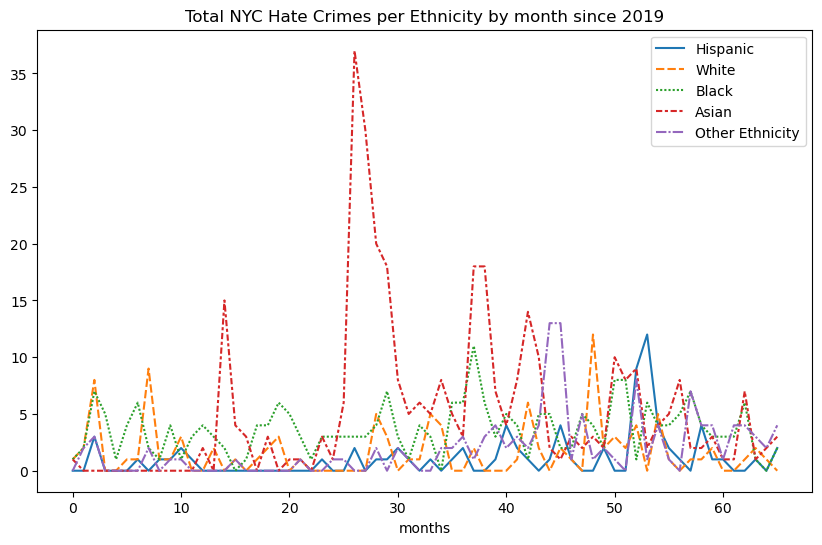

In [29]:
#Data: NOTE this data is used for three subsequent graphing
p2=['month_bin','bias','index_']
pv=df[p2].groupby(['month_bin','bias']).sum().reset_index()
pv1=pd.pivot_table(pv,index='month_bin', columns='bias', values=['index_']).reset_index().fillna(0)
pv1.columns= ['month','Asian','Black','Catholic','Gay','Hispanic','Jewish','Lesbian','Muslim',\
              'Other Ethnicity','Transgender','White']

#Table
plt.figure(figsize=(10,6))# Set the width and height of the figure
plt.title("Total NYC Hate Crimes per Ethnicity by month since 2019")
col= ['Hispanic','White','Black','Asian','Other Ethnicity']
bg=sns.lineplot(pv1[col]) #graphing
plt.xlabel("months") # Add label for horizontal axis
figure = bg.get_figure() 

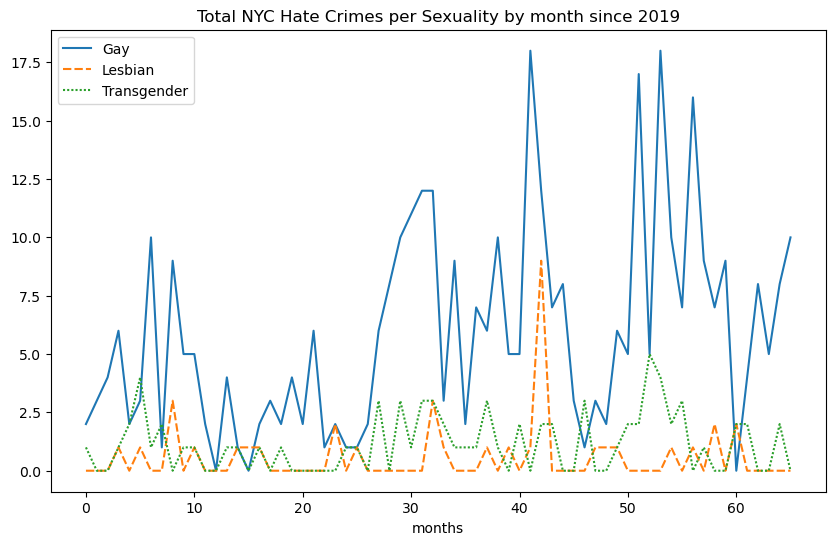

In [31]:
# Graphing by sexuality
plt.figure(figsize=(10,6))
plt.title("Total NYC Hate Crimes per Sexuality by month since 2019")
col= ['Gay','Lesbian','Transgender']
bg=sns.lineplot(pv1[col])
plt.xlabel("months")
figure = bg.get_figure() 

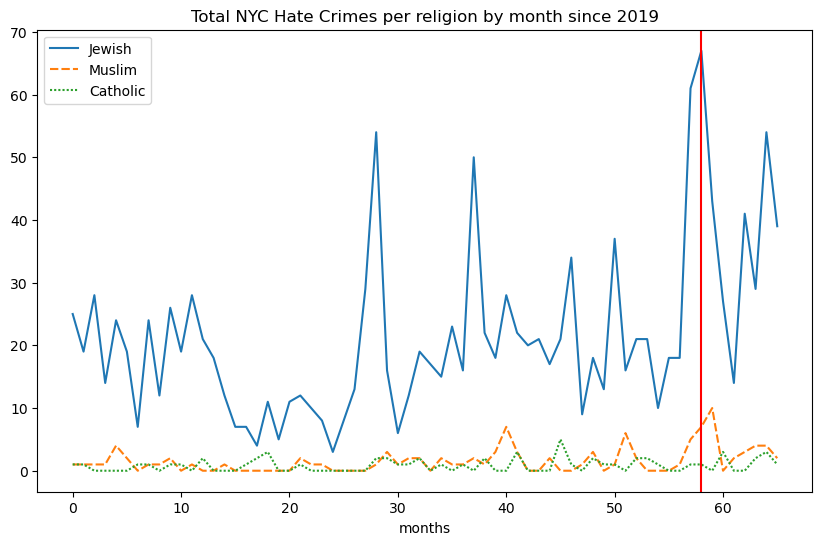

In [39]:
# Graphing by religion; a vertical line was added for October 7th
plt.figure(figsize=(10,6))
plt.title("Total NYC Hate Crimes per religion by month since 2019")
col= ['Jewish','Muslim','Catholic']
bg=sns.lineplot(pv1[col])
plt.xlabel("months")
plt.axvline(x=58, color='r') #added horizontal line for period near October 7th,2024
figure = bg.get_figure() 

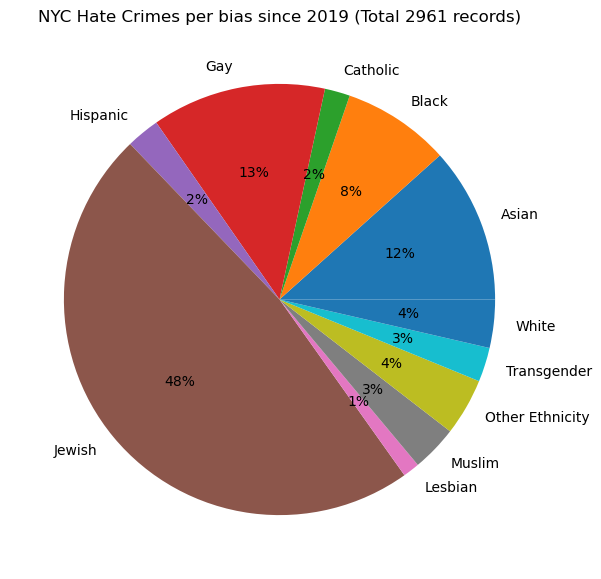

In [46]:
# Pie Chart of total bias
# Data 1: Prepare primary data
p2=['bias','index_']
gf=df[p2].groupby(['bias']).sum().reset_index()
gf.columns=['bias','Count']
Total = df.index_.sum() #variable is used for title

#Graphing
fig = plt.figure(figsize=(10, 7))
plt.pie(gf.Count, labels=gf.bias, autopct='%1.0f%%') #graphing
plt.title("NYC Hate Crimes per bias since 2019 (Total {} records)".format(Total))
plt.show()

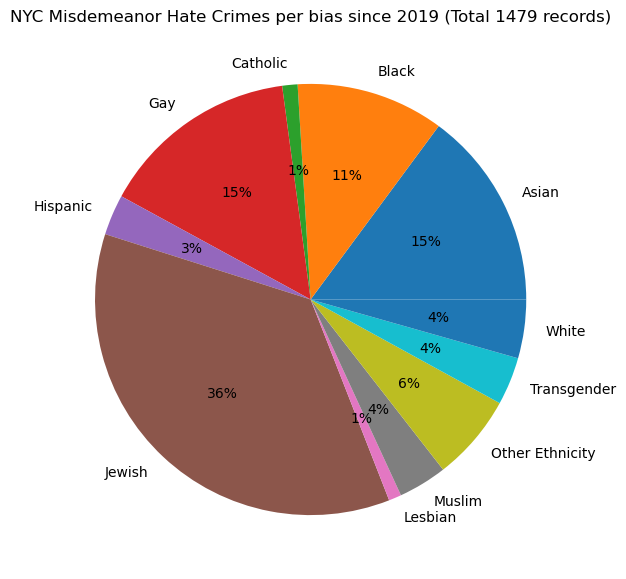

In [48]:
# Pie Chart of total bias conditioned on crime severity Misdemeanor
# Data 1: Prepare primary data
df1=df.query('crime_Category=="Misdemeanor"')
p2=['bias','index_']
gf=df1[p2].groupby(['bias']).sum().reset_index()
gf.columns=['bias','Count']
Total = df1.index_.sum() #variable is used for title

#Graphing
fig = plt.figure(figsize=(10, 7))
plt.pie(gf.Count, labels=gf.bias, autopct='%1.0f%%') #graphing
plt.title("NYC Misdemeanor Hate Crimes per bias since 2019 (Total {} records)".format(Total))
plt.show()

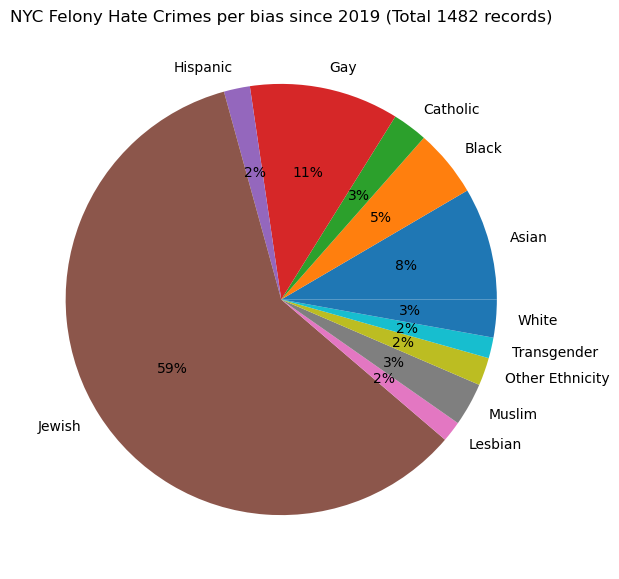

In [50]:
# Pie Chart of total bias conditioned on crime severity Felony
# Data 1: Prepare primary data
df1=df.query('crime_Category=="Felony"')
p2=['bias','index_']
gf=df1[p2].groupby(['bias']).sum().reset_index()
gf.columns=['bias','Count']
Total = df1.index_.sum() #variable is used for title

#Graphing
fig = plt.figure(figsize=(10, 7))
plt.pie(gf.Count, labels=gf.bias, autopct='%1.0f%%') #graphing
plt.title("NYC Felony Hate Crimes per bias since 2019 (Total {} records)".format(Total))
plt.show()

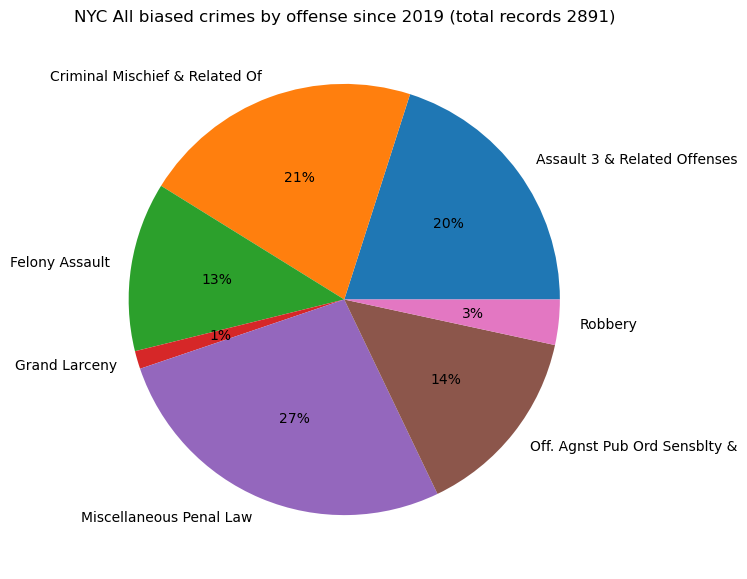

In [195]:
# Creating a function to specify biased groups and 'anti'
# MinCount specify the minimum count for categories to be seen
def pie_bias_Offenseplot(Bias='All',MinCount=20): 
    if Bias.startswith('non-')== True: #anti
        df1=df[(df['bias'] != Bias[4:])]
    elif Bias=='All':
        df1=df
    else:
        df1=df[(df['bias'] == Bias)]
    p2=['offense','index_']
    gf=df1[p2].groupby(['offense']).sum().reset_index()
    gf.columns=['offense','Count']
    gf=gf[(gf['Count'] > MinCount)]
    Total = gf.Count.sum()
    fig = plt.figure(figsize=(10, 7))
    plt.pie(gf.Count, labels=gf.offense, autopct='%1.0f%%')
    plt.title('NYC {} biased crimes by offense since 2019 (total records {})'.format(Bias,Total))
    plt.xlabel('')
    return plt.show() 

pie_bias_Offenseplot('All',20)

In [ ]:
pie_bias_Offenseplot('Jewish',20)

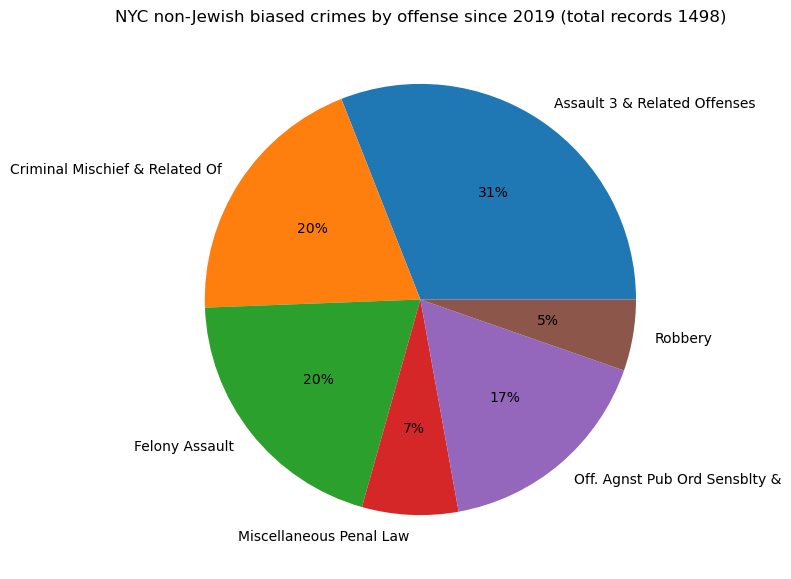

In [86]:
pie_bias_Offenseplot('non-Jewish',20)

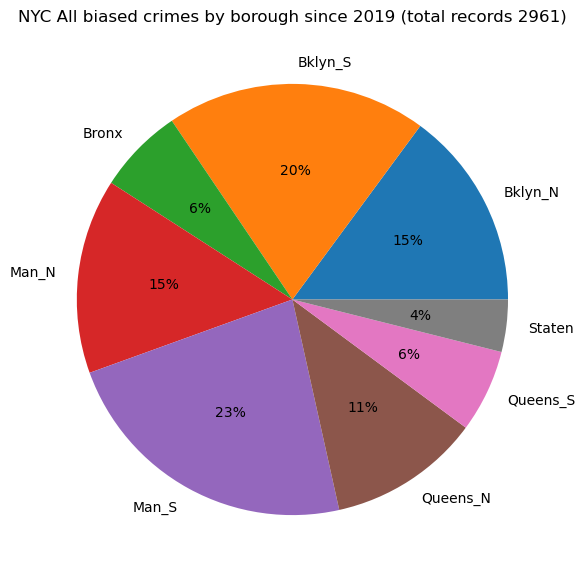

In [215]:
# Creating a function to specify biased groups on borough_add
# MinCount specify the minimum count for categories to be seen
def pie_bias_boroughplot(Bias='All',MinCount=20): 
    if Bias=='All':
        df1=df
    else:
        df1=df[(df['bias'] == Bias)]
    p2=['borough_add','index_']
    gf=df1[p2].groupby(['borough_add']).sum().reset_index()
    gf.columns=['borough_add','Count']
    gf=gf[(gf['Count'] > MinCount)]
    Total = gf.Count.sum()
    fig = plt.figure(figsize=(10, 7))
    plt.pie(gf.Count, labels=gf.borough_add, autopct='%1.0f%%')
    plt.title('NYC {} biased crimes by borough since 2019 (total records {})'.format(Bias,Total))
    plt.xlabel('')
    return plt.show() 

pie_bias_boroughplot('All',0)

## Mapping Requirements

* Initially I used chloropeth maps, but now I use geojson because of the floating feature
* We will be using precinct as the geo-coordinate. It was retrived here {here}.

In [92]:
#Import Libraries & Load Data
import requests # library to handle requests
import folium
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import geopandas
import json
import branca

# Open the GeoJSON file and load it into a dictionary
with open('nyc-police-precincts.geojson', 'r') as f:
    geojson_data = json.load(f)

# Check the type of the loaded data
print(type(geojson_data)) 

#prrepare Data
state= geopandas.GeoDataFrame.from_features(geojson_data, crs="EPSG:4326")
d=['geometry','precinct']
state= state[d]
print(type(state))

<class 'dict'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [94]:
#Preparing Data: The goal is to create a table grouped by the coordinate variable i.e. Precinct

# Get Total by Precinct
p=['precinct','index_']
d=['geometry','precinct']
df1=df[p].groupby(['precinct']).sum().reset_index()
df1.columns=['precinct','total']
A=pd.merge(state[d], df1, on='precinct', how='right') 

# Get Total by Offense1
p2=['precinct','offense1','index_']
pv=df[p2].groupby(['precinct','offense1']).sum().reset_index()
pv2=pd.pivot_table(pv,index='precinct', columns='offense1', values=['index_']).reset_index().fillna(0)
pv2.columns= ['precinct','Agst Public Order','Assault(Minor)','Criminal Mischief','Felony Assault','Grand Larceny','Misc. Penal Law','Other','Robbery']
B= pd.merge(A, pv2, on='precinct', how='right') 

# Get Total by Bias
p2=['precinct','bias','index_']
pv=df[p2].groupby(['precinct','bias']).sum().reset_index()
pv2=pd.pivot_table(pv,index='precinct', columns='bias', values=['index_']).reset_index().fillna(0)
pv2.columns= ['precinct','Asian','Black','Catholic','Gay','Hispanic','Jewish','Lesbian','Muslim','Other Ethnicity','Transgender','White']

#Final Merge
geomerge= pd.merge(B, pv2, on='precinct', how='right') 
geomerge.head(5) 

geometry precinct  total  \
0  MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...        1     78   
1  MULTIPOLYGON (((-74.00139 40.76285, -74.00051 ...       10     74   
2  MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...      100     15   
3  MULTIPOLYGON (((-73.76669 40.61425, -73.76665 ...      101     24   
4  MULTIPOLYGON (((-73.81710 40.70403, -73.81683 ...      102     24   

   Agst Public Order  Assault(Minor)  Criminal Mischief  Felony Assault  \
0               11.0             8.0               17.0             6.0   
1                9.0            16.0               15.0            16.0   
2                3.0             2.0                6.0             1.0   
3                3.0             7.0                3.0             4.0   
4                4.0             2.0                4.0             6.0   

   Grand Larceny  Misc. Penal Law  Other  ...  Black  Catholic   Gay  \
0            0.0             32.0    4.0  ...    6.0       0.0  10.0   
1            0.0             16.0    1.0  ...    9.0       5.0  23.0   
2            0.0              3.0    0.0  ...    3.0       1.0   2.0   
3            0.0              6.0    1.0  ...    1.0       0.0   2.0   
4            0.0              8.0    0.0  ...    1.0       0.0   2.0   

   Hispanic  Jewish  Lesbian  Muslim  Other Ethnicity  Transgender  White  
0       2.0    45.0      1.0     1.0              1.0          0.0    3.0  
1       3.0    16.0      0.0     0.0              6.0          3.0    2.0  
2       0.0     6.0      0.0     1.0              2.0          0.0    0.0  
3       2.0    16.0      0.0     0.0              0.0          1.0    0.0  
4       1.0    10.0      0.0     2.0              0.0          0.0    8.0  

[5 rows x 22 columns]

In [96]:
# GEOSCn Map

import branca

#Creates colored map, legend, and color scheme
colormap = branca.colormap.LinearColormap(
    vmin=geomerge["total"].quantile(0.0),
    vmax=geomerge["total"].quantile(1),
    colors=["white", "pink", "orange", "red", "darkred"],
    caption="NYC Hate Crimes Map by bias since 2019 ",
)

NYC_map = folium.Map(location=[40.7128466, -73.9138168], zoom_start=11.25, tiles="OpenStreetMap")

#When clicked
popup = folium.GeoJsonPopup(
    fields=['total','Agst Public Order','Assault(Minor)','Criminal Mischief','Felony Assault','Grand Larceny','Misc. Penal Law','Other','Robbery'],
    #aliases=["State", "% Change"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)

#when hover on
tooltip = folium.GeoJsonTooltip(
    fields=['precinct','Asian','Black','Catholic','Gay','Hispanic','Jewish','Lesbian','Muslim','Other Ethnicity','Transgender','White'],
    #aliases=["State:", "2015 Median Income(USD):", "Median % Change:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 1px;
        box-shadow: 1px;
    """,
    max_width=800,
)

#meat
g = folium.GeoJson(
    geomerge,
    style_function=lambda x: {
        "fillColor": colormap(x["properties"]["total"])
        if x["properties"]["total"] is not None
        else "transparent",
        "color": "black",
        "weight":1.5, #set thickness
        "fillOpacity": 0.4,
    },
    tooltip=tooltip,
    popup=popup,
).add_to(NYC_map)

colormap.add_to(NYC_map)

NYC_map



In [98]:
# Create GeoJson function; condition on biased group and hover on crime


def Geo_Bias_OffenseMap(Var1='All'):
    if Var1=='All':
        mf=df
    else:
        mf = df[(df['bias'] == Var1)]

    #geopanda item
    state1= state
    NYC_map = folium.Map(location=[40.7128466, -73.9138168], zoom_start=11.25, tiles="OpenStreetMap")
    # Get Total by Precinct
    p=['precinct','index_']
    df1=mf[p].groupby(['precinct']).sum().reset_index()
    df1.columns=['precinct','total']
    A=pd.merge(state1, df1, on='precinct', how='right') 

    # Get Total by Offense1
    p2=['precinct','offense1','index_']
    pv=mf[p2].groupby(['precinct','offense1']).sum().reset_index()
    pv2=pd.pivot_table(pv,index='precinct', columns='offense1', values=['index_']).reset_index().fillna(0)
    pv2.columns= ['precinct','Agst Public Order','Assault(Minor)','Criminal Mischief','Felony Assault','Grand Larceny','Misc. Penal Law','Other','Robbery']
    geomerge= pd.merge(A, pv2, on='precinct', how='right') 

    colormap = branca.colormap.LinearColormap(
    vmin=geomerge["total"].quantile(0.0),
    vmax=geomerge["total"].quantile(1),
    colors=["white", "pink", "orange", "red", "darkred"],
    caption=("{} Bias NYC Hate Crimes Map by offense since 2019".format(Var1)),
    )

    tooltip = folium.GeoJsonTooltip(
        fields=['precinct','total','Agst Public Order','Assault(Minor)','Criminal Mischief','Felony Assault','Grand Larceny','Misc. Penal Law','Other','Robbery'],
        #aliases=["State:", "2015 Median Income(USD):", "Median % Change:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 1px solid black;
            border-radius: 1px;
            box-shadow: 1px;
        """,
        max_width=800,
    )

    g = folium.GeoJson(
        geomerge,
        style_function=lambda x: {
            "fillColor": colormap(x["properties"]["total"])
            if x["properties"]["total"] is not None
            else "transparent",
            "weight":1.5, #set thickness
            "color": "black",
            "fillOpacity": 0.6,
        },
        tooltip=tooltip,
        #popup=popup,
    ).add_to(NYC_map)
    colormap.add_to(NYC_map)
    return NYC_map




In [100]:
Geo_Bias_OffenseMap('Asian')

In [102]:

df.to_csv('NYCHate_Abu.csv', index=False)

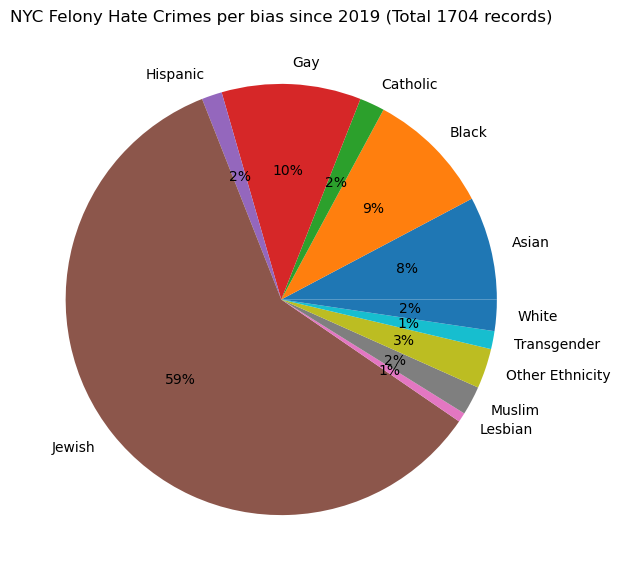

In [142]:

#Arrest ID is missing
# Pie Chart of total bias conditioned on crime severity Felony
# Data 1: Prepare primary data
df1=df.query('arrest_id.isnull()')
p2=['bias','index_']
gf=df1[p2].groupby(['bias']).sum().reset_index()
gf.columns=['bias','Count']
Total = df1.index_.sum() #variable is used for title

#Graphing
fig = plt.figure(figsize=(10, 7))
plt.pie(gf.Count, labels=gf.bias, autopct='%1.0f%%') #graphing
plt.title("NYC Felony Hate Crimes per bias since 2019 (Total {} records)".format(Total))
plt.show()

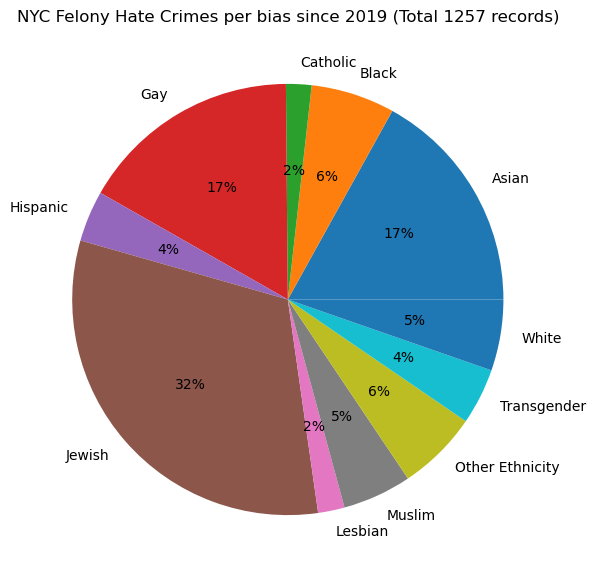

In [146]:

#Arrest ID there
# Pie Chart of total bias conditioned on crime severity Felony
# Data 1: Prepare primary data
df1=df.query('arrest_id.notnull()')
p2=['bias','index_']
gf=df1[p2].groupby(['bias']).sum().reset_index()
gf.columns=['bias','Count']
Total = df1.index_.sum() #variable is used for title

#Graphing
fig = plt.figure(figsize=(10, 7))
plt.pie(gf.Count, labels=gf.bias, autopct='%1.0f%%') #graphing
plt.title("NYC Felony Hate Crimes per bias since 2019 (Total {} records)".format(Total))
plt.show()